In [1]:
# http://learn.astropy.org/FITS-images.html

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os 
import glob

In [2]:
from astropy.utils.data import download_file
from astropy.io import fits

Very simple script which shows how to 

* combine images, 
* make a master bias and flat 
* process data using this master bias and flat. 


In [3]:
#ON IAP computers, set the path to this:
#data_dir = "/poubelles/broque1NS/tmp/hjmcc/tpnocturne-2019"

data_dir = "/Users/hjmcc/Dropbox/teaching/m1/tp-nocturne/2021/data-tpnocturne-2021/"
output_dir = "/Users/hjmcc/Dropbox/teaching/m1/tp-nocturne/2021/processed/"

In [4]:
image_file = os.path.join(data_dir,'Bias/Bias_1_secs_2021-11-22T18-10-46_001.fits')

In [5]:
image_file

'/Users/hjmcc/Dropbox/teaching/m1/tp-nocturne/2021/data-tpnocturne-2021/Bias/Bias_1_secs_2021-11-22T18-10-46_001.fits'

In [6]:
hdu_list = fits.open(image_file)

In [7]:
hdu_list.info()

Filename: /Users/hjmcc/Dropbox/teaching/m1/tp-nocturne/2021/data-tpnocturne-2021/Bias/Bias_1_secs_2021-11-22T18-10-46_001.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      28   (3352, 2532)   int16 (rescales to uint16)   


In [8]:
image_data = hdu_list[0].data

In [9]:
np.median(image_data[1000:2000,100:2000])

965.0

In [10]:
image_data = fits.getdata(image_file)
from matplotlib.colors import LogNorm

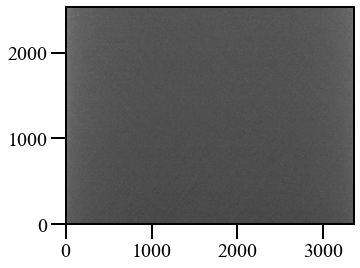

In [11]:
plt.imshow(image_data, cmap='gray', vmin=900,vmax=1100)


In [12]:
#image_list = glob.glob(data_dir+'Bias/test1_Bias_1_secs_2019*???.fits')
image_list = glob.glob('/Users/hjmcc/Dropbox/teaching/m1/tp-nocturne/2021/data-tpnocturne-2021/Bias/Bias*fits')
np.size(image_list)

21

In [13]:
image_list[1]

'/Users/hjmcc/Dropbox/teaching/m1/tp-nocturne/2021/data-tpnocturne-2021/Bias/Bias_1_secs_2021-12-02T16-54-09_019.fits'

In [14]:
# The long way
image_concat = []
for image in image_list:
    image_concat.append(fits.getdata(image))

In [16]:
final_bias = np.median(image_concat, axis=0)

In [17]:
fits.getdata(image).shape

(2532, 3352)

In [18]:
#final_image = np.zeros(shape=image_concat[0].shape)
#for image in image_concat:
#    final_image += image
#final_image = final_image / 10.0 

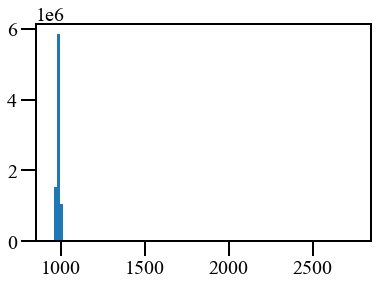

In [19]:
image_hist = plt.hist(final_bias.flatten(), bins=100)

In [20]:
np.std(final_bias[1000:2000,100:2000])

8.00442722864894

In [21]:
np.std(image_data[1000:2000,100:2000])/np.sqrt(21.0)

5.809556642117159

Note the noise in the master bias is *higher* than would expect from Poisson statistics. There
may be some other source of noise in the images (e.g., electrical noise) 

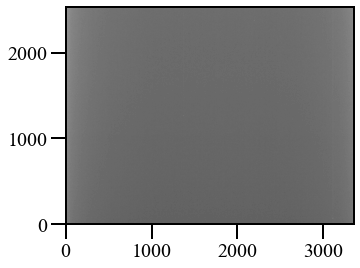

In [22]:
plt.imshow(final_bias, cmap='gray', vmin=900,vmax=1100)


In [32]:
outfile = output_dir+'median_bias2021.fits'
hdu = fits.PrimaryHDU(final_bias)
hdu.writeto(outfile, overwrite=True)

In [24]:
flat_list = glob.glob(data_dir+'/Flat/H_Alpha/Flat_H_Alpha_5_secs*fits')
np.size(flat_list)

10

In [25]:
image_concat = []
for image in flat_list:
    image_concat.append(fits.getdata(image)-final_bias)
# subtract the bias at each step. 

In [26]:
# now get final flat 
flat = np.median(image_concat, axis=0)

In [27]:
final_flat = flat/np.mean(flat) 

In [28]:
final_flat

array([[0.8982744 , 0.90763436, 0.89990957, ..., 1.04809017, 1.03867382,
        1.03856105],
       [0.92517019, 0.90368739, 0.89359442, ..., 1.05976193, 1.05784483,
        1.06427275],
       [0.90611195, 0.89432742, 0.88778673, ..., 1.06365251, 1.05649158,
        1.06038217],
       ...,
       [0.83100672, 0.84713292, 0.84188908, ..., 0.92223815, 0.93103426,
        0.92189984],
       [0.83303659, 0.82480434, 0.82627035, ..., 0.92178707, 0.91671239,
        0.91800925],
       [0.83585586, 0.82660867, 0.82689059, ..., 0.90695773, 0.92195623,
        0.9178401 ]])

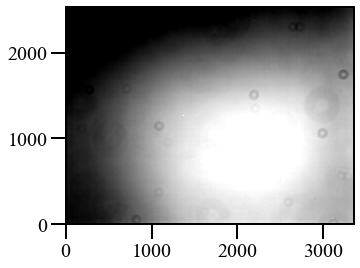

In [29]:
plt.imshow(final_flat, cmap='gray', vmin=0.9,vmax=1.1)


In [30]:
outfile = output_dir+'final_flatHa.fits'
hdu = fits.PrimaryHDU(final_flat)
hdu.writeto(outfile, overwrite=True)

In [31]:
image_list = glob.glob(data_dir+'Light/H_Alpha/M_57*30*fits')
np.size(image_list)

15

In [32]:
final_flat_trim=final_flat[:,1:]

In [33]:
final_bias_trim=final_bias[:,1:]

In [34]:
fits.getdata(image).shape

(2532, 3352)

In [35]:
import pathlib
#print(pathlib.Path(image).suffix)
filename,file_extension=os.path.splitext(image)
output_dir+os.path.basename(filename)+'_pr.fits'

'/Users/hjmcc/Dropbox/teaching/m1/tp-nocturne/2021/processed/Flat_H_Alpha_5_secs_2021-12-02T18-02-16_004_pr.fits'

Now process all images with this master flat and master bias. 

In [36]:
image_concat = []
for image in image_list:
#    print(fits.getdata(image).shape)
    processed = (fits.getdata(image)-final_bias_trim)/final_flat_trim
    image_concat.append(processed) 
    filename,file_extension=os.path.splitext(image)
    outfile=output_dir+os.path.basename(filename)+'_pr.fits'
    hdu = fits.PrimaryHDU(processed)
    hdu.writeto(outfile, overwrite=True)
    print(outfile)


/Users/hjmcc/Dropbox/teaching/m1/tp-nocturne/2021/processed/M_57_Light_H_Alpha_30_secs_2021-11-29T20-24-30_010_pr.fits
/Users/hjmcc/Dropbox/teaching/m1/tp-nocturne/2021/processed/M_57_Light_H_Alpha_30_secs_2021-11-29T20-22-21_006_pr.fits
/Users/hjmcc/Dropbox/teaching/m1/tp-nocturne/2021/processed/M_57_Light_H_Alpha_30_secs_2021-11-29T19-16-18_003_pr.fits
/Users/hjmcc/Dropbox/teaching/m1/tp-nocturne/2021/processed/M_57_Light_H_Alpha_30_secs_2021-11-29T19-17-22_005_pr.fits
/Users/hjmcc/Dropbox/teaching/m1/tp-nocturne/2021/processed/M_57_Light_H_Alpha_30_secs_2021-11-29T20-27-10_015_pr.fits
/Users/hjmcc/Dropbox/teaching/m1/tp-nocturne/2021/processed/M_57_Light_H_Alpha_30_secs_2021-11-29T19-16-50_004_pr.fits
/Users/hjmcc/Dropbox/teaching/m1/tp-nocturne/2021/processed/M_57_Light_H_Alpha_30_secs_2021-11-29T20-26-06_013_pr.fits
/Users/hjmcc/Dropbox/teaching/m1/tp-nocturne/2021/processed/M_57_Light_H_Alpha_30_secs_2021-11-29T20-23-58_009_pr.fits
/Users/hjmcc/Dropbox/teaching/m1/tp-nocturne/202